In [1]:
%matplotlib inline

from datetime import date, datetime, timedelta

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt

plt.style.use('seaborn-whitegrid')


In [2]:
df = pd.read_csv('programming_clean.csv')

In [3]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index().drop('level_0', axis=1)
    merged = pd.merge(
        df, source_data[group_columns],
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


In [4]:
def get_cats(series, idx_name=None):
    ser_name = series.name
    if idx_name is None:
        idx_name = ser_name + '_i'
    
    idx = (series.drop_duplicates().sort_values().reset_index(drop=True).reset_index()
           .set_index(ser_name)['index'].rename(idx_name).to_frame())
    return idx

In [5]:
data = df.copy()
data = data[data.employer_type != 'Во странство']
data.title.fillna('other', inplace=True)

title_idx = get_cats(data.title)
n_titles = title_idx.shape[0]

emptype_idx = get_cats(data.employer_type, idx_name='emptype_i')
n_emptype = emptype_idx.shape[0]

pos_idx = pd.Series(
    range(6),
    index=pd.Index(
        ['Lead', 'Senior', 'Middle', 'other', 'Junior', 'Практикант',][::-1],
        name='position'),
    name='position_i').to_frame()
n_pos = pos_idx.shape[0]

compsize_idx = get_cats(data.comp_size)
n_compsize = compsize_idx.shape[0]

edu_idx = pd.Series(
    range(5),
    index=pd.Index(
        ['Средно образование', 'Уште студирам дипломски', 'Завршени дипломски студии',
         'Завршени постдипломски студии', 'Доктор на науки'],
        name='edu'),
    name='edu_i').to_frame()
n_edu = edu_idx.shape[0]

pro_idx = pd.Series(
    range(5),
    index=pd.Index(
       ['помалку од 5', '5-10 години', '11-15 години', '16-20 години',
        'повеќе од 20 години'],
        name='pro_years'),
    name='pro_i').to_frame()
n_pro = pro_idx.shape[0]

data = (data.merge(title_idx, on='title')
        .merge(emptype_idx, on='employer_type')
        .merge(pos_idx, on='position')
        .merge(compsize_idx, on='comp_size')
        .merge(edu_idx, on='edu')
        .merge(pro_idx, on='pro_years'))

data = data.dropna().reset_index(drop=True)

log_net_mean, log_net_std = np.log(data.net).mean(), np.log(data.net).std()

data = data.assign(
    female = (data.sex == 'Женски').astype('int'),
    log_net_s = (np.log(data.net) - log_net_mean) / log_net_std
)

data = data[data.columns[9:]]

print(data.shape)
data.sample(5)

(737, 8)


,title_i,emptype_i,position_i,comp_size_i,edu_i,pro_i,female,log_net_s
55,0,2,3,2,2,1,1,-0.213872
175,7,2,5,2,3,1,1,0.990923
19,5,1,5,2,2,1,0,1.251193
330,5,2,4,3,2,0,1,0.541663
521,5,3,1,2,1,0,0,-0.148973


In [6]:
with pm.Model() as m2:
    a = pm.Normal('a', mu=0, sd=1.5)
    b_pos = pm.Normal('b_pos', mu=0, sd=1)
    b_pro = pm.Normal('b_pro', mu=0, sd=1)
    b_edu = pm.Normal('b_edu', mu=0, sd=1)
    b_female = pm.Normal('b_female', mu=0, sd=1)
    
    title_bar = pm.Exponential('title_bar', lam=1)
    title_a = pm.Normal('title_a', mu=0, sd=title_bar, shape=n_titles)

    compsize_bar = pm.Exponential('compsize_bar', lam=1)
    compsize_a = pm.Normal('compsize_a', mu=0, sd=compsize_bar, shape=n_compsize)

    K_emp = pm.LKJCholeskyCov(
        'K_emp', n=5, eta=1,
        sd_dist=pm.Exponential.dist(lam=1, shape=5)
    )
    emp = pm.MvNormal(
        'emp', mu=0,
        chol = pm.expand_packed_triangular(5, K_emp),
        shape=(n_emptype, 5)
    )
    
    emp_a = pm.Deterministic('emp_a', emp[:, 0])
    emp_pos = pm.Deterministic('emp_pos', emp[:, 1])
    emp_pro = pm.Deterministic('emp_pro', emp[:, 2])
    emp_edu = pm.Deterministic('emp_edu', emp[:, 3])
    emp_female = pm.Deterministic('emp_female', emp[:, 4])

    delta_pos = pm.Dirichlet('delta_pos', a=np.ones(n_pos-1))
    cum_pos = pm.Deterministic(
        'cum_pos',
        tt.as_tensor_variable(
            [pm.math.sum(delta_pos[0:end]) - 0.5
             for end in range(n_pos)]
        )
    )
    
    delta_pro = pm.Dirichlet('delta_pro', a=np.ones(n_pro-1))
    cum_pro = pm.Deterministic(
        'cum_pro',
        tt.as_tensor_variable(
            [pm.math.sum(delta_pro[0:end]) - 0.5
             for end in range(n_pro)]
        )
    )
    
    delta_edu = pm.Dirichlet('delta_edu', a=np.ones(n_edu-1))
    cum_edu = pm.Deterministic(
        'cum_edu',
        tt.as_tensor_variable(
            [pm.math.sum(delta_edu[0:end]) - 0.5
             for end in range(n_edu)]
        )
    )

    A = (a + title_a[data.title_i.values]
         + emp_a[data.emptype_i.values]
         + compsize_a[data.comp_size_i.values])
    B_pos = b_pos + emp_pos[data.emptype_i.values]
    B_pro = b_pro + emp_pro[data.emptype_i.values]
    B_edu = b_edu + emp_edu[data.emptype_i.values]
    B_female = b_female + emp_female[data.emptype_i.values]
    
    log_net_s = pm.Deterministic(
        'log_net_s',
        A
        + B_pos * cum_pos[data.position_i.values]
        + B_pro * cum_pro[data.pro_i.values]
        + B_edu * cum_edu[data.edu_i.values]
        + B_female * data.female.values
    )
    
    sigma = pm.HalfCauchy('sigma', beta=5)
    obs = pm.Normal('obs', mu=log_net_s, sd=sigma,
                    observed=data.log_net_s.values)
    
    m2.name = 'm2'
#     m2.trace = pm.sample(1500, tune=3500, chains=2)
#     pm.save_trace(m2.trace)

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [10]:
with m2:
    m2.trace = pm.load_trace(directory='.pymc_2.trace/')

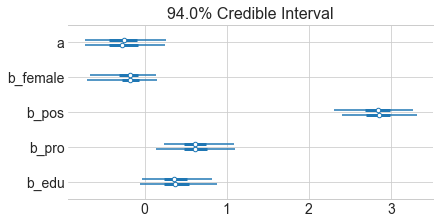

In [108]:
fig, axes = pm.plot_forest(m2.trace,
                           var_names=['a', 'b_female', 'b_pos', 'b_pro', 'b_edu'],
                           figsize=(6, 3))
axes[0].grid()
None

**Заклучок**: Најголем ефект на платата има позицијата (рангот junior --> lead)

## Категориски ефекти

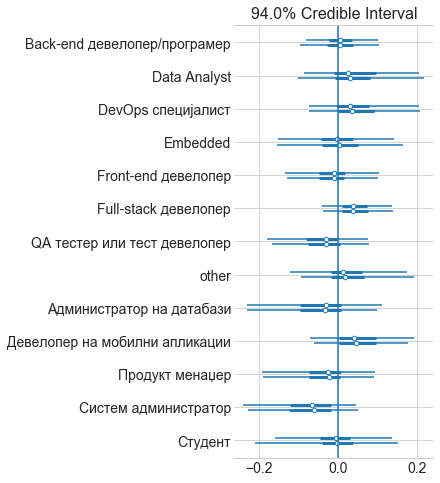

In [9]:
fig, axes = pm.plot_forest(m2.trace, var_names=['title_a'])
axes[0].grid()
axes[0].set(yticklabels=title_idx.index.values[::-1])
axes[0].axvline(0)
None

**Заклучок**: Категоријата `Студент` не покажува варијација зашто студентите се практикант/јуниор, па ефектот на позицијата е веќе земен во предвид.

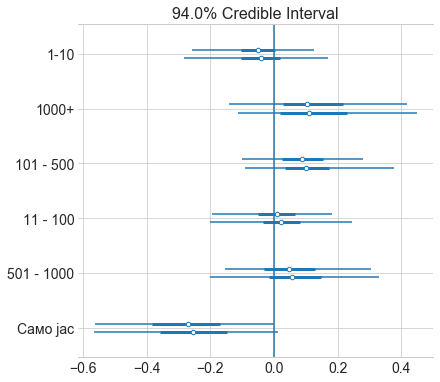

In [13]:
fig, axes = pm.plot_forest(m2.trace, var_names=['compsize_a'])
axes[0].grid()
axes[0].set(yticklabels=compsize_idx.index.values[::-1])
axes[0].axvline(0)
None

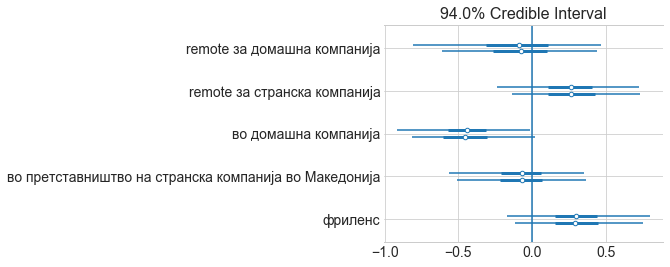

In [15]:
fig, axes = pm.plot_forest(m2.trace, var_names=['emp_a'], figsize=(5, 4))
axes[0].grid()
axes[0].set(yticklabels=emptype_idx.index.values[::-1])
axes[0].axvline(0)
None

**Заклучок**: Варијацијата на ефектите е најголема кај типот на договор за вработување, најмала варијација има видот на работа (`backend`, `frontent`, ...)

### Кумулативни ефекти
Следниве три табели се однесуваат на кумулативни ефекти, e.g., `Middle` секогаш има поголем ефект од `Junior` (таканаречени подредени категории). Ефектите се скалирани од -0.5 до +0.5, Нулата се однесува на просечниот актор.

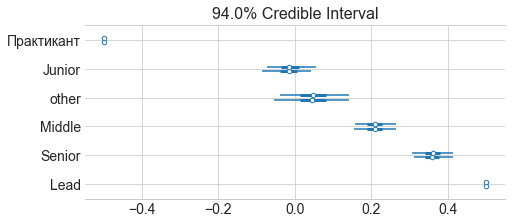

In [11]:
fig, axes = pm.plot_forest(m2.trace, var_names=['cum_pos'], figsize=(7, 3))
axes[0].grid()
axes[0].set(yticklabels=pos_idx.index.values[::-1])
None

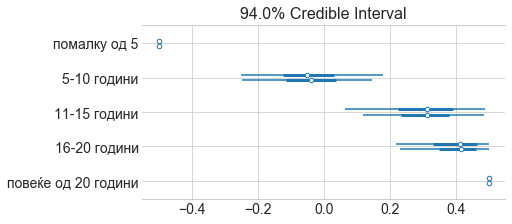

In [16]:
fig, axes = pm.plot_forest(m2.trace, var_names=['cum_pro'], figsize=(7, 3))
axes[0].grid()
axes[0].set(yticklabels=pro_idx.index.values[::-1])
None

**Заклучок**: Луѓето со над 10 години веќе се сметаат за професионалци и сѐ над тоа има само diminished returns.

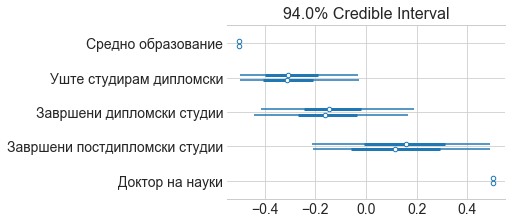

In [17]:
fig, axes = pm.plot_forest(m2.trace, var_names=['cum_edu'], figsize=(7, 3))
axes[0].grid()
axes[0].set(yticklabels=edu_idx.index.values[::-1])
None

## Комплетна проценка

In [90]:
test_data = (
    title_idx.reset_index().assign(key=0)
    .merge(compsize_idx.reset_index().assign(key=0))
    .merge(emptype_idx.reset_index().assign(key=0))
    .merge(pos_idx.reset_index().assign(key=0))
    .merge(pro_idx.reset_index().assign(key=0))
    .merge(edu_idx.reset_index().assign(key=0))
    .merge(pd.Series([0, 1], name='female').to_frame().assign(key=0))
).drop('key', axis=1)

test_data = test_data.assign(
    A = (m2.trace['a'].mean(axis=0)
         + m2.trace['title_a'].mean(axis=0)[test_data.title_i]
         + m2.trace['emp_a'].mean(axis=0)[test_data.emptype_i]
         + m2.trace['compsize_a'].mean(axis=0)[test_data.comp_size_i]),
    B_pos = (m2.trace['b_pos'].mean(axis=0)
             + m2.trace['emp_pos'].mean(axis=0)[test_data.emptype_i]),
    B_pro = (m2.trace['b_pro'].mean(axis=0)
             + m2.trace['emp_pro'].mean(axis=0)[test_data.emptype_i]),
    B_edu = (m2.trace['b_edu'].mean(axis=0)
             + m2.trace['emp_edu'].mean(axis=0)[test_data.emptype_i]),
    B_female = (m2.trace['b_female'].mean(axis=0)
             + m2.trace['emp_female'].mean(axis=0)[test_data.emptype_i]),
)

test_data = test_data.assign(
    net = np.exp(
        (
            test_data.A
            + test_data.B_pos * m2.trace['cum_pos'].mean(axis=0)[test_data.position_i]
            + test_data.B_pro * m2.trace['cum_pro'].mean(axis=0)[test_data.pro_i]
            + test_data.B_edu * m2.trace['cum_edu'].mean(axis=0)[test_data.edu_i]
            + test_data.B_female * test_data.female
        )
        * log_net_std 
        + log_net_mean
    )
)
test_data = test_data.drop(['title_i', 'emptype_i', 'position_i', 'comp_size_i',
                            'pro_i', 'edu_i', 'A' ,'B_pos', 'B_pro', 'B_edu', 'B_female'],
                           axis=1)
test_data = test_data.assign(net = test_data.net.map(lambda n: np.round(n, -2)).astype('int'))

test_data.to_csv('all_means.csv', index=False, header=True)

Најголеми / најмали плати

In [27]:
test_data.nlargest(9, 'net')

,title,comp_size,employer_type,position,pro_years,edu,female,net
83098,Девелопер на мобилни апликации,1000+,remote за странска компанија,Lead,повеќе од 20 години,Доктор на науки,0,247700
83998,Девелопер на мобилни апликации,1000+,фриленс,Lead,повеќе од 20 години,Доктор на науки,0,247000
20098,DevOps специјалист,1000+,remote за странска компанија,Lead,повеќе од 20 години,Доктор на науки,0,246600
47098,Full-stack девелопер,1000+,remote за странска компанија,Lead,повеќе од 20 години,Доктор на науки,0,246100
11098,Data Analyst,1000+,remote за странска компанија,Lead,повеќе од 20 години,Доктор на науки,0,246000
20998,DevOps специјалист,1000+,фриленс,Lead,повеќе од 20 години,Доктор на науки,0,245900
47998,Full-stack девелопер,1000+,фриленс,Lead,повеќе од 20 години,Доктор на науки,0,245400
11998,Data Analyst,1000+,фриленс,Lead,повеќе од 20 години,Доктор на науки,0,245300
84598,Девелопер на мобилни апликации,101 - 500,remote за странска компанија,Lead,повеќе од 20 години,Доктор на науки,0,243200


In [34]:
test_data.nsmallest(7, 'net')[::-1]

,title,comp_size,employer_type,position,pro_years,edu,female,net
35101,Embedded,Само јас,во домашна компанија,Практикант,помалку од 5,Средно образование,1,6300
8101,Back-end девелопер/програмер,Само јас,во домашна компанија,Практикант,помалку од 5,Средно образование,1,6300
44101,Front-end девелопер,Само јас,во домашна компанија,Практикант,помалку од 5,Средно образование,1,6200
98101,Продукт менаџер,Само јас,во домашна компанија,Практикант,помалку од 5,Средно образование,1,6100
80101,Администратор на датабази,Само јас,во домашна компанија,Практикант,помалку од 5,Средно образование,1,6100
62101,QA тестер или тест девелопер,Само јас,во домашна компанија,Практикант,помалку од 5,Средно образование,1,6100
107101,Систем администратор,Само јас,во домашна компанија,Практикант,помалку од 5,Средно образование,1,6000


## Gender pay gap

In [109]:
test_gender = (
    emptype_idx.reset_index().assign(key=0)
    .merge(pd.Series([0, 1], name='female').to_frame().assign(key=0))
).drop('key', axis=1)

test_gender = test_gender.assign(
    A = (m2.trace['a'].mean(axis=0)
         + m2.trace['emp_a'].mean(axis=0)[test_gender.emptype_i]),
    B_female = (m2.trace['b_female'].mean(axis=0)
             + m2.trace['emp_female'].mean(axis=0)[test_gender.emptype_i]),
)

test_gender = test_gender.assign(
    net = np.exp(
        (
            test_gender.A
            + test_gender.B_female * test_gender.female
        )
        * log_net_std 
        + log_net_mean
    )
)

test_gender = test_gender.set_index(['employer_type', 'female']).net.unstack().sort_values(0)
test_gender = test_gender.assign(rel_diff = 1-test_gender[1]/test_gender[0])
test_gender = test_gender.reset_index()

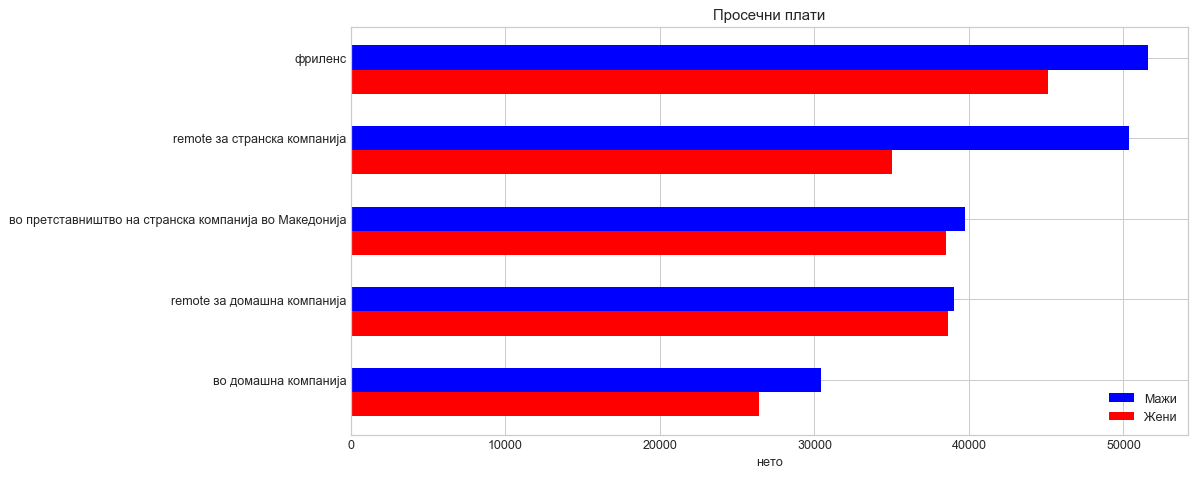

In [112]:
plt.figure(figsize=(12, 6), dpi=90)
plt.barh(test_gender.index, test_gender[0], height=.3, color='b', label='Мажи')
plt.barh(test_gender.index -.3, test_gender[1], height=.3, color='r', label='Жени')
plt.gca().set(
    yticks = test_gender.index,
    yticklabels=test_gender.employer_type,
    xlabel=('нето'),
    title='Просечни плати'
)
plt.legend()
None

**Заклучок**: Постои систематски gender pay gap. Разликите се движат од 1 до 31% помали плати за жените.

In [115]:
test_gender[['employer_type', 'rel_diff']].set_index('employer_type').sort_values('rel_diff')

female,rel_diff
employer_type,
remote за домашна компанија,0.010311
во претставништво на странска компанија во Македонија,0.031481
фриленс,0.124883
во домашна компанија,0.130553
remote за странска компанија,0.305335
